<a href="https://colab.research.google.com/github/meliksahb/Design-of-Intelligent-Machines-ME536-/blob/main/CharacterDetectionCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--2025-01-05 11:56:15--  https://raw.githubusercontent.com/bugrakoku/data4all/main/crashed.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14301 (14K) [image/jpeg]
Saving to: ‘crashed.jpg’

crashed.jpg         100%[===================>]  13.97K  --.-KB/s    in 0s      

2025-01-05 11:56:15 (28.9 MB/s) - ‘crashed.jpg’ saved [14301/14301]



Text(0.5, 1.0, 'just checking the crash.jpg image... no worries yet...')

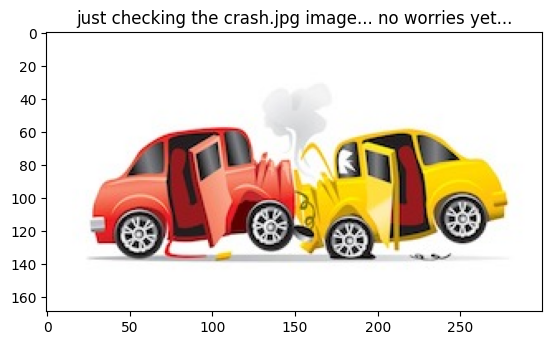

In [1]:
# test codes -to be added to the end of your code
# the SearchInAlphabetSoup() function you wrote will be called several times
# during this test.

# import for imread, just in case
import matplotlib.pyplot as plt
from matplotlib.image import imread
from timeit import default_timer as timer
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random

# get the necessary file
!rm *.jpg 2>/dev/null
!wget https://raw.githubusercontent.com/bugrakoku/data4all/main/crashed.jpg



def GenImage(numLetters = 50, fixedFontSize = True, xCount = 15, yCount = 10, pos = [], cvals = [] ):
    '''
    Input:
        numLetters = maximum number of letters
        fixedFontSize = well doug
        xCount, yCount = number of rows and columns
        pos and cvals = pre-allocated positions of characters

    Output:
        image as numpy array that contains letters randomly located
    '''
    # in the assignment assessment following will not change in test images
    fontname = '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf'
    cellSize = 30 #cell within which a single char will be printed
    BackColor = (255,255, 255) # back color
    ForeColor = (0, 0, 0) # font color
    charz = ['B', 'U', 'D', 'R', 'K', 'A', 'E', '6', 'N']
    # in the assignment assessment variable above will not change in generating test images
    fR = 0.8 # font ratio to cell size
    # generate an empty list to be filled in randomly
    #charmap = [['' for i in range(xCount)] for j in range(yCount)] # assign

    fontsize = int(cellSize * fR) # fixed font size
    nB = int(cellSize*(1-fR)) # location noise

    img = Image.new('RGB', (xCount*cellSize,yCount*cellSize), BackColor ) # blank image
    imgPen = ImageDraw.Draw(img) # pen to draw on the blank image

    # first generate random positions over pos
    # note that pos might be already partially filled in
    for i in range(len(pos), numLetters):
        x = np.random.randint(0, xCount)
        y = np.random.randint(0, yCount)
        if [y,x] not in pos:
            pos.append([y,x])
            cvals.append(random.choice(charz))
    print(f'size: {len(pos)}:{len(cvals)}')
    # now that positions are determined, print random letters in them
    for ([y,x], txt) in zip(pos, cvals): # draw each letter if random location is not already occupied, if occupied, skip
        if not fixedFontSize: # if set so, select a random font size
            fontsize = np.random.randint(12, cellSize-1)
            dx, dy = 0, 0 # when scaled, position does not change
        else: # add some location noise
            dx = int(np.random.rand()* nB)
            dy = int(np.random.rand()* nB)
        font = ImageFont.truetype(fontname, fontsize) # font instace created
        imgPen.text((x * cellSize + dx, y * cellSize + dy), txt, font=font, fill=ForeColor) # write the character to blank image


    return np.array(img) # finally return image as an numpy array

test_basic = ['simplest']
test_more = ['simple', 'test50', 'test100']
test_pro = ['test150', 'test250', 'test400', 'testInsane']
test_all = test_basic + test_more + test_pro
# the following are variable font size cases
test_basicF = ['simplestF']
test_moreF = ['simpleF', 'test50F', 'test100F']
test_ProF = ['test150F', 'test250F', 'test400F', 'testInsaneF']
test_allF = test_basicF + test_moreF + test_ProF

def PerformTest(cases = ['simplest'], figSize = (25,25)):
    shapes = ['KARE', 'BUDUR', '6KENAR']
    crash = imread('crashed.jpg')
    imgz = []
    imgTitles = []
    for case in cases:
        img = np.load(f'{case}.npy')
        for shape in shapes:
            startTime = timer()
            try:
                print(f'Searching for {shape} in {case} ')
                imgR = SearchInAlphabetSoup(img.copy(), shape)
                imgz.append(imgR)
            except:
                imgz.append(crash)
            endTime = timer()
            imgTitles.append(f'{shape} in {case}: {round(endTime-startTime, 3)} sec.')
            print(imgTitles[-1])

    # finally plot the results
    fig, axz = plt.subplots(len(imgz), 1, figsize=figSize)
    for i, ax in enumerate(axz):
        ax.imshow(imgz[i])
        ax.set_title(imgTitles[i])

# make suer the crashed image shows up
plt.imshow(plt.imread('crashed.jpg'))
plt.title('just checking the crash.jpg image... no worries yet...')

size: 15:15
size: 15:15
size: 27:27
size: 27:27
size: 50:50
size: 47:47
test50
test50F
size: 88:88
size: 85:85
test100
test100F
size: 129:129
size: 126:126
test150
test150F
size: 160:160
size: 164:164
test200
test200F
size: 181:181
size: 186:186
test250
test250F
size: 212:212
size: 210:210
test300
test300F
size: 237:237
size: 234:234
test350
test350F
size: 257:257
size: 259:259
test400
test400F
size: 620:620
testInsane25
size: 819:819
testInsane29
size: 1017:1017
testInsane33


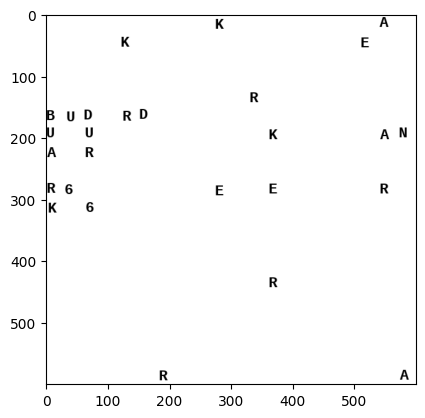

In [2]:
# simplest case
ch = ['K', 'A', 'R', 'E',
      'B', 'U', 'D', 'U', 'R',
      '6', 'K', 'E', 'N', 'A', 'R'
]
pos = [[0,9], [0,13], [4,13], [4, 9],
        [5,0], [5,1], [5,2], [6,2], [7,2],
        [10, 5], [7,7], [7,11], [10, 13 ], [13,11], [13,7],
]
img = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=len(pos))
imgF = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=len(pos))
np.save('simplest', img)
np.save('simplestF', imgF)

# simple case
ch = ['K', 'A', 'R', 'E',
      'A', 'R', 'E',
      'B', 'U', 'D', 'U', 'R',
      'U', 'A', 'R', 'K',
      'R', 'D',
      'K', '6', 'R',
      '6', 'K', 'E', 'N', 'A', 'R'
      ]
pos = [[0,9], [0,18], [9,18], [9, 9],
        [6, 18], [4, 11], [9, 12],
        [5,0], [5,1], [5,2], [6,2], [7,2],
        [6,0], [7,0], [9,0], [10,0],
        [5,4], [5,5],
        [6, 12], [10, 2], [14, 12] ]

# add slightly randomized 6KENAR
pos.append([np.random.randint(7, 17), 1]) #6
pos.append([1, np.random.randint(0, 6)]) #K
pos.append([1, np.random.randint(14, 20)]) #E
pos.append([np.random.randint(4, 8), 19]) #N
pos.append([np.random.randint(17, 20), 19]) #A
pos.append([19, np.random.randint(5, 13)]) #R

img = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=len(pos))
imgF = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=len(pos))
plt.imshow(img)
np.save('simple', img)
np.save('simpleF', imgF)


# fixed font size cases
for i in range(50,401,50):
    img = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=i)
    imgF = GenImage(fixedFontSize=False, pos = pos.copy(), cvals=ch.copy(), xCount=20, yCount=20, numLetters=i)
    np.save(f'test{i}', img)
    np.save(f'test{i}F', imgF)
    print(f'test{i}')
    print(f'test{i}F')
for i in range(25,36,4):
  imgInsane = GenImage(pos = pos.copy(), cvals=ch.copy(), xCount=i, yCount=i, numLetters=3000)
  np.save(f'testInsane{i}',imgInsane)
  print(f'testInsane{i}')



In [3]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define characters and font
CHARZ = ['B', 'U', 'D', 'R', 'K', 'A', 'E', '6', 'N']
FONT_PATH = '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf'
IMG_SIZE = 30  # Cell size
fR = 0.8
nB = int(IMG_SIZE*(1-fR))
# Generate synthetic data
def create_training_data(font_path, charz, img_size=30, num_samples_per_char=1000):
    training_data = []
    labels = []
    for idx, char in enumerate(charz):
        for _ in range(num_samples_per_char):
            # Create an image with a single character
            img = Image.new('RGB', (img_size, img_size), (255, 255, 255))
            draw = ImageDraw.Draw(img)
            font = ImageFont.truetype(font_path, size=np.random.randint(12, IMG_SIZE-1))
            x_offset = int(np.random.rand()* nB)
            y_offset = int(np.random.rand()* nB)
            draw.text((x_offset, y_offset), char, font=font, fill=(0, 0, 0))

            # Convert to grayscale and normalize
            img_array = np.array(img.convert('L'))
            training_data.append(img_array)
            labels.append(idx)

    training_data = np.array(training_data).reshape(-1, img_size, img_size, 1) / 255.0
    labels = np.array(labels)
    return training_data, labels

# Generate training data
X, y = create_training_data(FONT_PATH, CHARZ)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build the CNN
def build_cnn(input_shape=(30, 30, 1), num_classes=len(CHARZ)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the CNN
model = build_cnn()

# Train the CNN
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# # Display training history
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# Save the model
model.save('character_recognition_model.h5')

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.4544 - loss: 1.5584 - val_accuracy: 0.9867 - val_loss: 0.0888
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.9906 - loss: 0.0642 - val_accuracy: 1.0000 - val_loss: 0.0147
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9997 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 9.9470e-04
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 1.0000 - loss: 9.2508e-04 - val_accuracy: 1.0000 - val_loss: 8.3647e-04
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 1.0000 - loss: 5.9199e-04 - 

Test Accuracy: 1.00


In [19]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from PIL import ImageColor


# Define character set and colors
CHARZ = ['B', 'U', 'D', 'R', 'K', 'A', 'E', '6', 'N']
CHAR_COLORS = {
    'B': "pink", 'U': "yellow", 'D': "green", 'R': "orange",
    'K': "red", 'A': "cyan", 'E': "magenta", '6': "blue", 'N': "purple"
}
FONT_PATH = "/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf"  # Adjust as needed

# Load the saved CNN model
model = load_model('/content/character_recognition_model.h5')

char_locations = {char: [] for char in CHARZ}

# Function to preprocess test image and extract cells
def preprocess_gen_image(img, cell_size=30):
    """
    Preprocess the generated image to extract cells and their locations.
    """
    img_array = np.array(img)
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    cells = []
    locations = []
    for y in range(0, img_array.shape[0], cell_size):
        for x in range(0, img_array.shape[1], cell_size):
            cell = gray[y:y+cell_size, x:x+cell_size]
            if np.sum(cell < 255) > 10:  # Check for non-white pixels
                cells.append(cell)
                locations.append((x, y))
    cells = np.array(cells).reshape(-1, cell_size, cell_size, 1) / 255.0
    return cells, locations


# Function to annotate and display results
def annotate_image(img, locations, predictions, cell_size=30):
    """
    Annotate the image with predicted characters and colors.
    """
    draw = ImageDraw.Draw(img)

    img_array = np.array(img)
    for (x, y), pred_idx in zip(locations, predictions):
        char = CHARZ[pred_idx]
        color = CHAR_COLORS[char]
        # Color the rectangle without overwriting the character
        draw.rectangle([x, y, x + cell_size, y + cell_size], outline=color, width=2)

        # Convert color name to RGB
        rgb_color = ImageColor.getrgb(color)

       # Extract the region of interest (ROI) for the character
        roi = img.crop((x, y, x + cell_size, y + cell_size))

        # Convert the ROI to a numpy array for processing
        roi_array = np.array(roi)

        # Identify the pixels that belong to the character (non-white pixels)
        mask = np.all(roi_array < [200, 200, 200], axis=-1)  # Adjust threshold as needed

        # Apply the color to the detected character
        roi_array[mask] = rgb_color  # Apply the color to the detected character

        # Convert back to an image and paste it back into the original image
        img.paste(Image.fromarray(roi_array), (x, y))

        # Store the character's location
        char_locations[char].append((x + cell_size / 2, y + cell_size / 2))

# Function to test the CNN on saved images
def test_saved_images(image_paths, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for img_path in image_paths:
        # Load the test image
        img = np.load(img_path)
        img = Image.fromarray(img.astype('uint8'))  # Convert to PIL Image

        # Preprocess the image to extract cells and their locations
        cells, locations = preprocess_gen_image(img)

        # Predict characters using the CNN
        predictions = np.argmax(model.predict(cells), axis=1)

        annotate_image(img, locations, predictions)

        # Save the annotated image
        output_path = os.path.join(output_folder, os.path.basename(img_path).replace('.npy', '_annotated.png'))
        img.save(output_path)
        print(f"Processed and saved: {output_path}")

# Paths to test images
image_folder = '/content/'
image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.npy')]

# Output folder for annotated images
output_folder = "/content/"

# Test on the saved images
test_saved_images(image_paths, output_folder)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Processed and saved: /content/test300F_annotated.png
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Processed and saved: /content/test300_annotated.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Processed and saved: /content/simpleF_annotated.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Processed and saved: /content/simple_annotated.png
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processed and saved: /content/testInsane33_annotated.png
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Processed and saved: /content/test400_annotated.png
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Processed and saved: /content/test150_annotated.png
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processed and saved: /content/test350F_annotated.png
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processed and saved: /content/test350_annotated.png
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Processed and saved: /content/test250F_annotated.png
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Processed and saved: /content/test50_annotated.png
20/20

In [41]:
import numpy as np
import math
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Function to calculate distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

# Function to calculate the angle between three points (in degrees)
def calculate_angle(p1, p2, p3):
    # Vector from p2 to p1
    vector1 = np.array([p1[0] - p2[0], p1[1] - p2[1]])
    # Vector from p2 to p3
    vector2 = np.array([p3[0] - p2[0], p3[1] - p2[1]])

    # Dot product and magnitude of vectors
    dot_product = np.dot(vector1, vector2)
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)

    # Calculate the angle in radians and convert to degrees
    cos_theta = dot_product / (magnitude1 * magnitude2)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return np.degrees(angle)

# Function to check if four points form a perfect square
def is_perfect_square(k_centers, a_centers, r_centers, e_centers):
    distances = []
    angles = []

    # Calculate distances between consecutive points
    for i in range(len(k_centers)):
        distances.append(calculate_distance(k_centers[i], a_centers[i]))

    # Check if all four distances are equal (sides of square)
    if not np.allclose(distances[0], distances[1]) or not np.allclose(distances[1], distances[2]) or not np.allclose(distances[2], distances[3]):
        print("Distances are not equal, not a square.")
        return False

    # Calculate angles between consecutive points (should be 90 degrees)
    for i in range(4):
        angle = calculate_angle(pts[i], pts[(i + 1) % 4], pts[(i + 2) % 4])
        angles.append(angle)
        print(f"Angle {i} -> {angle}")

    # Check if all angles are 90 degrees
    if not np.allclose(angles[0], 90) or not np.allclose(angles[1], 90) or not np.allclose(angles[2], 90) or not np.allclose(angles[3], 90):
        print("Angles are not 90 degrees, not a square.")
        return False

    return True

In [44]:
def SearchInAlphabetSoup(img_path, txt='KARE'):
    # Extracting the centers of the specified characters in order
    k_centers = [char_locations['K']]
    a_centers = [char_locations['A']]
    r_centers = [char_locations['R']]
    e_centers = [char_locations['E']]

    # Check if the points form a perfect square
    if is_perfect_square(k_centers, a_centers, r_centers, e_centers):
        # If a perfect square is found, draw the square on the image
        img = Image.open(img_path)
        draw = ImageDraw.Draw(img)

        # Draw lines connecting the points in the order 'K' -> 'A' -> 'R' -> 'E' -> 'K'
        draw.line([centers[0], centers[1]], fill="red", width=2)  # K -> A
        draw.line([centers[1], centers[2]], fill="red", width=2)  # A -> R
        draw.line([centers[2], centers[3]], fill="red", width=2)  # R -> E
        draw.line([centers[3], centers[0]], fill="red", width=2)  # E -> K

        # Display the output image
        plt.imshow(img)
        plt.axis('off')  # Turn off axis
        plt.show()
    else:
        print("No perfect square found.")



In [45]:
# Paths to test images
image_folder = '/content/'
image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.png')]

# Test on the saved images
for i in range(len(image_paths)):
  SearchInAlphabetSoup(image_paths[i], 'KARE')


TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'